# Generative Adversarial Network (GAN) Tutorial

In this tutorial we'll see how to code a simple Generative Adversarial Network (GAN) to generate handwritten digits that resemble those found in the MNSIT dataset.


## Resources

The following are great resources for learning more about GANs.

1. [Generative Adversarial Nets (Goodfellow et al.)](https://arxiv.org/pdf/1406.2661.pdf) -- the paper that introduced GANs
2. [An Introduction to GANs in Tensorflow](http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/)
3. [Generative Models Blog Post from OpenAI](https://blog.openai.com/generative-models/)

In [10]:
from __future__ import absolute_import, division
from __future__ import print_function

import itertools
import math
import time

import autograd
from autograd import grad
import autograd.numpy as np

import matplotlib.pyplot as plt
from IPython import display

from data import load_mnist, save_images

%matplotlib inline

## Load Dataset

In [58]:
N, train_images, train_labels, test_images, test_labels = load_mnist()

## Visualize Dataset Examples

In [75]:
def plot_grid(image_matrix, num_samples=25):
    """Plot a square grid of sample images.
    """

    # create figure for plotting
    size_figure_grid = int(math.sqrt(num_samples))
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
    
    for k in range(num_samples):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i,j].cla()
        ax[i,j].imshow(image_matrix[k,:].reshape(28, 28), cmap='Greys_r')
#     display.clear_output(wait=True)
#     display.display(plt.gcf())

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1]


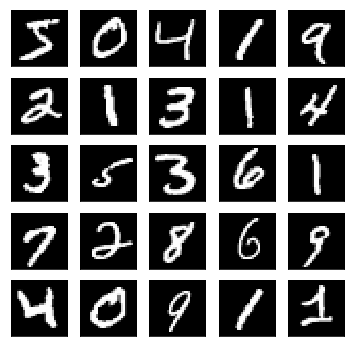

In [77]:
show_indexes = range(0, 25)
plot_grid(train_images[show_indexes])
print([train_labels[idx].nonzero()[0][0] for idx in show_indexes]) # Show the labels of the examples

## Define the Model



In [175]:
def init_bias(scale, output_size):
    return scale * np.random.randn(output_size)

def init_weight(scale, input_size, output_size):
    return scale * np.random.randn(input_size, output_size)

def init_G_params(noise_size, image_size, scale=0.001):
    return {
            'G_fc1_W': init_weight(scale, noise_size, 200),
            'G_fc1_b': init_bias(scale, 200),
            'G_fc2_W': init_weight(scale, 200, 400),
            'G_fc2_b': init_bias(scale, 400),
            'G_fc3_W': init_weight(scale, 400, image_size),
            'G_fc3_b': init_bias(scale, image_size)
           }

def init_D_params(image_size, output_size, scale=0.001):
     return {
             'D_fc1_W': init_weight(scale, image_size, 400),
             'D_fc1_b': init_bias(scale, 400),
             'D_fc2_W': init_weight(scale, 400, 200),
             'D_fc2_b': init_bias(scale, 200),
             'D_fc3_W': init_weight(scale, 200, output_size),
             'D_fc3_b': init_bias(scale, output_size)
            }

In [176]:
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def batch_normalize(activations):
    mbmean = np.mean(activations, axis=0, keepdims=True)
    return (activations - mbmean) / (np.std(activations, axis=0, keepdims=True) + 1)

In [177]:
def G(params, z):
    """Generates a batch of images from random noise vectors z.
    
    Input: A batch of noise samples, arranged in a matrix of dimension BATCH_SIZE x NOISE_DIM
    Output: A batch of generated images, arranged in a matrix of dimension BATCH_SIZE x IMAGE_SIZE
    """
    # Forward pass through the generator
    G_params = params['G_params']
    x = np.dot(z, G_params['G_fc1_W']) + G_params['G_fc1_b']
    x = batch_normalize(x)
    x = relu(x)
    
    x = np.dot(x, G_params['G_fc2_W']) + G_params['G_fc2_b']
    x = batch_normalize(x)
    x = relu(x)
    
    output = np.dot(x, G_params['G_fc3_W']) + G_params['G_fc3_b']
    return output

In [178]:
def D(params, x):
    """Takes a batch of images x and returns a batch of scores that indicate how confident the discriminator
    is that the each image is real.
    
    Input: A batch of images x, in a matrix of dimension BATCH_SIZE x IMAGE_SIZE
    Output: A batch of real/fake scores, in a matrix of dimension BATCH_SIZE x 1
    """
    # Forward pass through the discriminator
    D_params = params['D_params']
    y = np.dot(x, D_params['D_fc1_W']) + D_params['D_fc1_b']
    y = batch_normalize(y)
    y = relu(y)
    
    y = np.dot(y, D_params['D_fc2_W']) + D_params['D_fc2_b']
    y = batch_normalize(y)
    y = relu(y)
    
    output = np.dot(y, D_params['D_fc3_W']) + D_params['D_fc3_b']
    # print(output)
    output = sigmoid(output)
    return output

In [179]:
def binary_cross_entropy(outputs, targets):
    # loss(o,t)=−1/n∑i(t[i]∗log(o[i])+(1−t[i])∗log(1−o[i]))
    
    loss = np.sum(-(targets * np.log(outputs + 1e-6)) - ((1 - targets) * np.log(1 - outputs + 1e-6)))
    return loss / outputs.shape[0]

In [189]:
def D_loss(params, real_images, fake_images):
    D_real_out = D(params, real_images)
    D_fake_out = D(params, fake_images)
    
    D_real_loss = binary_cross_entropy(D_real_out, np.ones(batch_size))
    D_fake_loss = binary_cross_entropy(D_fake_out, np.zeros(batch_size))
    D_total_loss = D_real_loss + D_fake_loss
    
    return D_total_loss


def G_loss(params):
    
    # Sample random noise from a Gaussian distribution
    z = np.random.randn(batch_size, noise_dimension)
    fake_images = G(params, z)
    
    D_fake_out = D(params, fake_images)
        
    # print(D_fake_out)
    # The generator wants to fool the discriminator; that is, it wants the discriminator to assign high 
    # probability (close to 1) to the fake images it generates.
    loss = binary_cross_entropy(D_fake_out, np.ones(batch_size))
    return loss

D_loss_grad = grad(D_loss)
G_loss_grad = grad(G_loss)

### Prepare to show generated samples during training

In [ ]:
num_test_samples = 25
fixed_noise = np.random.randn(num_test_samples, noise_dimension)

# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    
def display_samples(image_matrix, num_samples=25):
    # reshaped_generated_images = fake_images.view(batch_size, 28, 28)
    
    for k in range(num_test_samples):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i,j].cla()
        ax[i,j].imshow(image_matrix[k,:].reshape(28, 28), cmap='Greys_r')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

### Train the GAN

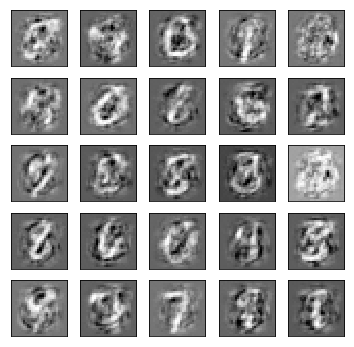

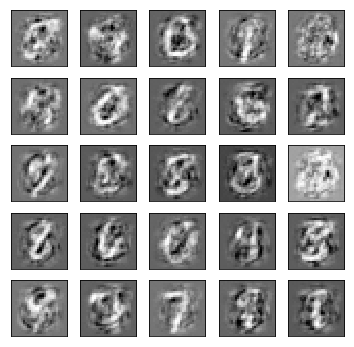

In [195]:
# Training hyperparameters
param_scale = 0.001
noise_dimension = 10
image_size = 784  # 28 * 28

batch_size = 100
num_epochs = 10
learning_rate = 0.005  # for SGD

# Initialize model parameters
params = {
        'G_params': init_G_params(noise_dimension, image_size, param_scale),
        'D_params': init_D_params(image_size, 1, param_scale)
    }

num_batches = math.ceil(train_images.shape[0] / batch_size)

iteration = 0
display_every = 400

for epoch in range(num_epochs):
    
    for batch_index in range(num_batches):
        
        start_index = batch_index * batch_size
        end_index = start_index + batch_size
        
        real_images = train_images[start_index:end_index]
        
        # Sample random noise from a Gaussian distribution
        z = np.random.randn(batch_size, noise_dimension)
        fake_images = G(params, z)
        
        # Update the discriminator
        D_grad_params = D_loss_grad(params, real_images, fake_images)
        for param in params['D_params']:
            params['D_params'][param] = params['D_params'][param] - learning_rate * D_grad_params['D_params'][param]
        
        
        # Update the generator
        G_grad_params = G_loss_grad(params)
        for param in params['G_params']:
            params['G_params'][param] = params['G_params'][param] - learning_rate * G_grad_params['G_params'][param]
        
        
        # Show generated samples periodically, to inspect the generator qualitatively
        if iteration % display_every == 0:
            D_total_loss = D_loss(params, real_images, fake_images)
            G_total_loss = G_loss(params)
            
            test_images = G(params, fixed_noise)
            display_samples(test_images, num_samples=num_test_samples)
            
            print("D loss = {}".format(D_total_loss))
            print("G loss = {}".format(G_total_loss))
        
        iteration += 1

## Conditional GAN, a.k.a. "Give me a 5!"

The vanilla GAN we have just implemented does not take into account the class of an image; thus, while it can produce realistic images that look like ones from the training set, it cannot produce images of a specific, desired class, such as only images of the number 5. We can extend the vanilla GAN by incorporating extra conditioning information, for example to specify which class we want it to generate. To do this, we pass a conditioning vector $c$ to both the generator and discriminator, so they become $G(z, c)$ and $D(x, c)$, respectively. Then the generator $G$ can take into account which class it is supposed to generate, and $D$ can score how realistic a generated image is, given that it is intended to represent a specific class.

Then, the objective function of the discriminator becomes:
$$
J_D = \mathbb{E}_{x \sim p_{data}} [ - \log D(x, c) ] + \mathbb{E}_z [ - \log(1 - D(G(z, c), c)) ]
$$

And the objective function of the generator becomes:
$$
J_G = \mathbb{E}_{z \sim q(z)} [ - \log D(G(z, c), c) ]
$$